In [1]:
import pandas as pd
import json
import requests
import gspread
import geopandas as gpd
import numpy as np
import json

from oauth2client.service_account import ServiceAccountCredentials

/Users/maier-borst.h/Documents/CodeRelated/HBDataviz/2024/24_PegelDaten/Wrangle/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [12]:
#this is used later when you want to update a google spreadsheet with the data


#scope = ['https://spreadsheets.google.com/feeds',        'https://www.googleapis.com/auth/drive']
#credentials = ServiceAccountCredentials.from_json_keyfile_name('pegel-data-caa6786701ae.json', scope)

In [20]:
#this is the url that shows the list of all currently run stations
url="https://www.pegelonline.wsv.de/webservices/rest-api/v2/stations.json?includeTimeseries=true&includeCurrentMeasurement=true?includeCharacteristicValues=true"



In [21]:
#we get back a json with these stations
resp = requests.get(url=url)
data = resp.json() 
data[0]

{'uuid': '47174d8f-1b8e-4599-8a59-b580dd55bc87',
 'number': '48900237',
 'shortname': 'EITZE',
 'longname': 'EITZE',
 'km': 9.56,
 'agency': 'VERDEN',
 'longitude': 9.276769435375872,
 'latitude': 52.90406544743417,
 'water': {'shortname': 'ALLER', 'longname': 'ALLER'},
 'timeseries': [{'shortname': 'W',
   'longname': 'WASSERSTAND ROHDATEN',
   'unit': 'cm',
   'equidistance': 15,
   'gaugeZero': {'unit': 'm. ü. NN',
    'value': 8.0,
    'validFrom': '1985-03-13'}}]}

In [22]:
#and we restructure this json to only containingn, name, ide and lat lon
#because we only want to know which stations are in a certain boundary later
dictofpegels={}
listofpegels=data
for element in listofpegels:
    try:
        dictofpegels[element["longname"]]=[element["number"],element["latitude"],element["longitude"]]
    except:
        pass
sorted(dictofpegels)[:5]

['AALBUDE',
 'ABBENFLETH SPERRWERK',
 'ACHLEITEN',
 'ACHTHÖFENER FLETH SIEL',
 'AFFOLDERN']

In [16]:
# as a dataframe this looks like this
pegeldf=pd.DataFrame(dictofpegels).T.reset_index()
pegeldf.columns=["Name","Nummer","lat","lon"]
pegeldf

,Name,Nummer,lat,lon
0,EITZE,48900237,52.904065,9.276769
1,RETHEM,48900204,52.789098,9.382841
2,AHLDEN,48900102,52.762431,9.570881
3,MARKLENDORF,48700103,52.682757,9.703456
4,CELLE,48300105,52.622706,10.062164
...,...,...,...,...
657,MESCHERIN,603520,53.250883,14.436439
658,DORNBUSCH BRÜCKE,126009,53.737776,9.348017
659,WISCHHAFEN SPERRWERK,126008,53.785178,9.340786
660,BORGFELD,4940010,53.133971,8.894403


<Axes: >

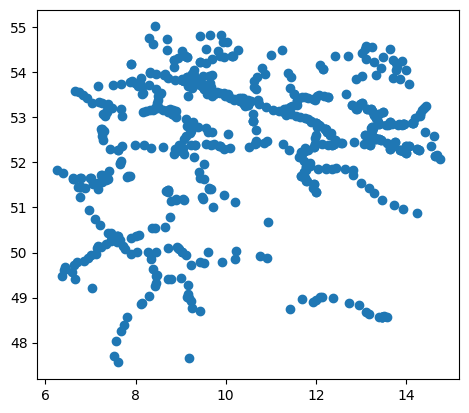

In [23]:
#mapped out looks like this
pegel_geometry = gpd.GeoDataFrame(
    pegeldf, geometry=gpd.points_from_xy(pegeldf.lon, pegeldf.lat))
pegel_geometry.plot()

In [18]:
# now we want to check which stations are in a certain shape, in this case berlin and brandenburg
from shapely.geometry import Polygon, LineString, Point

<Axes: >

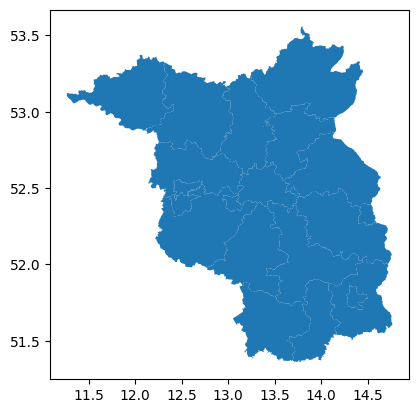

In [19]:
#we get the shapefile reproject it
rbb_shape=gpd.read_file("../data/Brandenburg-Landkreise.shp")
rbb_shape.to_crs(epsg=4326, inplace=True)
rbb_shape.plot()

In [10]:
# and check through a geopandas sjoin which points are within the shape
points_within = gpd.sjoin(pegel_geometry, rbb_shape, op='within')
points_within

/Users/maier-borst.h/Documents/CodeRelated/HBDataviz/2024/24_PegelDaten/Wrangle/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/55/79cxhkf56b38c317w6g5zkr0mmx5lp/T/ipykernel_85429/2750149270.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  points_within = gpd.sjoin(pegel_geometry, rbb_shape, op='within')


,Name,Nummer,lat,lon,geometry,index_right,AREA,PERIMETER,KREISE_,KREISE_ID,PUNKT_NR,OBJEKT,LK_NAME
5,BERLIN-PLÖTZENSEE OP,586640,52.5437,13.323142,POINT (13.32314 52.54370),8,890121679.50000,218837.54863,10.00000,9.00000,0.00000,None,Berlin
6,BERLIN-PLÖTZENSEE UP,586650,52.543036,13.323859,POINT (13.32386 52.54304),8,890121679.50000,218837.54863,10.00000,9.00000,0.00000,None,Berlin
9,BERLIN-SCHMÖCKWITZ,586810,52.374398,13.653581,POINT (13.65358 52.37440),8,890121679.50000,218837.54863,10.00000,9.00000,0.00000,None,Berlin
10,NEUE MÜHLE SCHLEUSE UP,586280,52.297475,13.649641,POINT (13.64964 52.29747),18,2276216465.50000,435921.38448,20.00000,19.00000,0.00000,None,LDS
11,NEUE MÜHLE SCHLEUSE OP,586270,52.296816,13.651758,POINT (13.65176 52.29682),18,2276216465.50000,435921.38448,20.00000,19.00000,0.00000,None,LDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,MARIENTHAL OP,581390,53.051362,13.292737,POINT (13.29274 53.05136),3,1804996637.00000,358549.66694,5.00000,4.00000,0.00000,None,OHV
606,EICHHORST OP,693320,52.891138,13.639019,POINT (13.63902 52.89114),4,1501865574.00000,330052.60553,6.00000,5.00000,0.00000,None,BAR
607,EICHHORST UP,693330,52.891424,13.638876,POINT (13.63888 52.89142),4,1501865574.00000,330052.60553,6.00000,5.00000,0.00000,None,BAR
656,GARTZ,603510,53.206333,14.394265,POINT (14.39426 53.20633),0,3078637529.00000,386860.25786,2.00000,1.00000,0.00000,None,UM


In [24]:
#we reduce this file to name, id, lat, lon and the name of the district aka Landkreis
pegelstationen_in_rbb_gebiet=points_within[["Name","Nummer","lat","lon","LK_NAME"]]
pegelstationen_in_rbb_gebiet=pegelstationen_in_rbb_gebiet.reset_index(drop=True)
pegelstationen_in_rbb_gebiet

,Name,Nummer,lat,lon,LK_NAME
0,BERLIN-PLÖTZENSEE OP,586640,52.5437,13.323142,Berlin
1,BERLIN-PLÖTZENSEE UP,586650,52.543036,13.323859,Berlin
2,BERLIN-SCHMÖCKWITZ,586810,52.374398,13.653581,Berlin
3,NEUE MÜHLE SCHLEUSE UP,586280,52.297475,13.649641,LDS
4,NEUE MÜHLE SCHLEUSE OP,586270,52.296816,13.651758,LDS
...,...,...,...,...,...
115,MARIENTHAL OP,581390,53.051362,13.292737,OHV
116,EICHHORST OP,693320,52.891138,13.639019,BAR
117,EICHHORST UP,693330,52.891424,13.638876,BAR
118,GARTZ,603510,53.206333,14.394265,UM


In [29]:
# and now we iterate through this dataframe
maindictofvals={}
for index, row in pegelstationen_in_rbb_gebiet.iterrows():
    # get the id number for each row
    idnumber=(row["Nummer"])
    #and do two requests, one to the past data
    url_past="https://www.pegelonline.wsv.de/webservices/rest-api/v2/stations/"+idnumber+"/W.json?includeCharacteristicValues=true"
    resp = requests.get(url=url_past)
    data_past = resp.json() 

    #one to the current data
    url_current="https://www.pegelonline.wsv.de/webservices/rest-api/v2/stations/"+idnumber+"/W/measurements.json"
    resp = requests.get(url=url_current)
    data_curr = resp.json()
    #we get the current data and turn it into a dataframe
    curr_df=pd.DataFrame(data_curr)
    #we reformat the timestamp
    curr_df["timestamp"]=curr_df["timestamp"].str[:-15]
    #and in case we have two measurements on the same day, we keep only the last entry 
    curr_df=curr_df.drop_duplicates(subset=["timestamp"],keep="last")
    curr_df=curr_df.reset_index(drop=True)
    #we set the index to timestamp and the value to the column and then build a dictionary  
    dictionary_vals = curr_df.set_index('timestamp')['value'].to_dict()
    #then we go through the data from the past json and interate through the characteristicValues
    for i in range(len(data_past['characteristicValues'])):
        # that we put as well to the dictionary, characteristic values are things like high water mark etc.
        dictionary_vals[data_past['characteristicValues'][i]["longname"]]=data_past['characteristicValues'][i]["value"]
    #and lastly we add this dictionary with current data and characteristic values into another dictionary/object
    #that has the id number of the location as a key
    maindictofvals[idnumber]=dictionary_vals

In [28]:
#we then turn this into a dataframe using a transform once
df_pegelstaende=pd.DataFrame(maindictofvals).T
df_pegelstaende

,2024-06-08,2024-06-09,2024-06-10,2024-06-11,2024-06-12,2024-06-13,2024-06-14,2024-06-15,2024-06-16,2024-06-17,2024-06-18,Niedrigster Niedrigwasserstand,Höchster Hochwasserstand,Mittel der Niedrigwasserstände,Mittel der Tageswasserstände,Mittel der Hochwasserstände,höchster Schifffahrtswasserstand,Marke_I,Marke_II
586640,350.0,349.0,349.0,348.0,348.0,347.0,347.0,348.0,348.0,348.0,347.0,284.0,371.0,319.0,339.0,356.0,NaN,NaN,NaN
586650,274.0,273.0,274.0,273.0,273.0,272.0,271.0,272.0,274.0,273.0,273.0,216.0,371.0,271.0,274.0,292.0,NaN,NaN,NaN
586810,39.0,39.0,39.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,38.0,28.0,63.0,35.0,39.0,50.0,NaN,NaN,NaN
586280,124.0,124.0,124.0,123.0,123.0,123.0,123.0,122.0,123.0,123.0,123.0,90.0,215.0,120.0,126.0,140.0,NaN,NaN,NaN
586270,268.0,267.0,266.0,266.0,266.0,266.0,266.0,266.0,266.0,266.0,266.0,202.0,298.0,257.0,265.0,275.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581390,278.0,278.0,278.0,278.0,278.0,278.0,278.0,279.0,279.0,279.0,281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693320,409.0,410.0,410.0,409.0,409.0,409.0,408.0,409.0,409.0,409.0,408.0,327.0,419.0,385.0,402.0,415.0,NaN,NaN,NaN
693330,111.0,111.0,112.0,112.0,112.0,111.0,110.0,111.0,111.0,111.0,113.0,NaN,NaN,88.0,105.0,120.0,NaN,NaN,NaN
603510,511.0,512.0,508.0,526.0,519.0,527.0,525.0,525.0,523.0,527.0,520.0,430.0,739.0,475.0,531.0,618.0,630.0,NaN,630.0


In [31]:
#we reset the index
df_pegelstaende=df_pegelstaende.reset_index().rename(columns={"index":"number"})
df_pegelstaende

,number,2024-06-08,2024-06-09,2024-06-10,2024-06-11,2024-06-12,2024-06-13,2024-06-14,2024-06-15,2024-06-16,...,Niedrigster Niedrigwasserstand,Höchster Hochwasserstand,Mittel der Niedrigwasserstände,Mittel der Tageswasserstände,Mittel der Hochwasserstände,höchster Schifffahrtswasserstand,Marke_I,Marke_II,niedrigwassercounter,hochwassercounter
0,586640,350.0,349.0,349.0,348.0,348.0,347.0,347.0,348.0,348.0,...,284.0,371.0,319.0,339.0,356.0,NaN,NaN,NaN,1,0
1,586650,274.0,273.0,274.0,273.0,273.0,272.0,271.0,272.0,274.0,...,216.0,371.0,271.0,274.0,292.0,NaN,NaN,NaN,1,0
2,586810,39.0,39.0,39.0,38.0,38.0,38.0,38.0,38.0,38.0,...,28.0,63.0,35.0,39.0,50.0,NaN,NaN,NaN,1,0
3,586280,124.0,124.0,124.0,123.0,123.0,123.0,123.0,122.0,123.0,...,90.0,215.0,120.0,126.0,140.0,NaN,NaN,NaN,1,0
4,586270,268.0,267.0,266.0,266.0,266.0,266.0,266.0,266.0,266.0,...,202.0,298.0,257.0,265.0,275.0,NaN,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,581390,278.0,278.0,278.0,278.0,278.0,278.0,278.0,279.0,279.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
116,693320,409.0,410.0,410.0,409.0,409.0,409.0,408.0,409.0,409.0,...,327.0,419.0,385.0,402.0,415.0,NaN,NaN,NaN,1,0
117,693330,111.0,111.0,112.0,112.0,112.0,111.0,110.0,111.0,111.0,...,NaN,NaN,88.0,105.0,120.0,NaN,NaN,NaN,0,0
118,603510,511.0,512.0,508.0,526.0,519.0,527.0,525.0,525.0,523.0,...,430.0,739.0,475.0,531.0,618.0,630.0,NaN,630.0,1,0


In [32]:
#we clean up the column names of white space
df_pegelstaende.columns=df_pegelstaende.columns.str.strip()
#and we add two columns to count how often the high and low water mark where surpassed
df_pegelstaende["niedrigwassercounter"]=0
df_pegelstaende["hochwassercounter"]=0

for col in df_pegelstaende.columns[1:12]:
    # and we check for this using np.where()
    df_pegelstaende["niedrigwassercounter"]=np.where(df_pegelstaende[col]<df_pegelstaende['Mittel der Niedrigwasserstände'],df_pegelstaende["niedrigwassercounter"]+1,df_pegelstaende["niedrigwassercounter"])
    df_pegelstaende["hochwassercounter"]=np.where(df_pegelstaende[col]>df_pegelstaende['Mittel der Hochwasserstände'],df_pegelstaende["hochwassercounter"]+1,df_pegelstaende["hochwassercounter"])

df_pegelstaende

,number,2024-06-08,2024-06-09,2024-06-10,2024-06-11,2024-06-12,2024-06-13,2024-06-14,2024-06-15,2024-06-16,...,Niedrigster Niedrigwasserstand,Höchster Hochwasserstand,Mittel der Niedrigwasserstände,Mittel der Tageswasserstände,Mittel der Hochwasserstände,höchster Schifffahrtswasserstand,Marke_I,Marke_II,niedrigwassercounter,hochwassercounter
0,586640,350.0,349.0,349.0,348.0,348.0,347.0,347.0,348.0,348.0,...,284.0,371.0,319.0,339.0,356.0,NaN,NaN,NaN,0,0
1,586650,274.0,273.0,274.0,273.0,273.0,272.0,271.0,272.0,274.0,...,216.0,371.0,271.0,274.0,292.0,NaN,NaN,NaN,0,0
2,586810,39.0,39.0,39.0,38.0,38.0,38.0,38.0,38.0,38.0,...,28.0,63.0,35.0,39.0,50.0,NaN,NaN,NaN,0,0
3,586280,124.0,124.0,124.0,123.0,123.0,123.0,123.0,122.0,123.0,...,90.0,215.0,120.0,126.0,140.0,NaN,NaN,NaN,0,0
4,586270,268.0,267.0,266.0,266.0,266.0,266.0,266.0,266.0,266.0,...,202.0,298.0,257.0,265.0,275.0,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,581390,278.0,278.0,278.0,278.0,278.0,278.0,278.0,279.0,279.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
116,693320,409.0,410.0,410.0,409.0,409.0,409.0,408.0,409.0,409.0,...,327.0,419.0,385.0,402.0,415.0,NaN,NaN,NaN,0,0
117,693330,111.0,111.0,112.0,112.0,112.0,111.0,110.0,111.0,111.0,...,NaN,NaN,88.0,105.0,120.0,NaN,NaN,NaN,0,0
118,603510,511.0,512.0,508.0,526.0,519.0,527.0,525.0,525.0,523.0,...,430.0,739.0,475.0,531.0,618.0,630.0,NaN,630.0,0,0


In [35]:
Pegel_count_Data=pd.merge(pegelstationen_in_rbb_gebiet,df_pegelstaende,right_on="number",left_on="Nummer")
Pegel_count_Data

,Name,Nummer,lat,lon,LK_NAME,number,2024-06-08,2024-06-09,2024-06-10,2024-06-11,...,Niedrigster Niedrigwasserstand,Höchster Hochwasserstand,Mittel der Niedrigwasserstände,Mittel der Tageswasserstände,Mittel der Hochwasserstände,höchster Schifffahrtswasserstand,Marke_I,Marke_II,niedrigwassercounter,hochwassercounter
0,BERLIN-PLÖTZENSEE OP,586640,52.5437,13.323142,Berlin,586640,350.0,349.0,349.0,348.0,...,284.0,371.0,319.0,339.0,356.0,NaN,NaN,NaN,0,0
1,BERLIN-PLÖTZENSEE UP,586650,52.543036,13.323859,Berlin,586650,274.0,273.0,274.0,273.0,...,216.0,371.0,271.0,274.0,292.0,NaN,NaN,NaN,0,0
2,BERLIN-SCHMÖCKWITZ,586810,52.374398,13.653581,Berlin,586810,39.0,39.0,39.0,38.0,...,28.0,63.0,35.0,39.0,50.0,NaN,NaN,NaN,0,0
3,NEUE MÜHLE SCHLEUSE UP,586280,52.297475,13.649641,LDS,586280,124.0,124.0,124.0,123.0,...,90.0,215.0,120.0,126.0,140.0,NaN,NaN,NaN,0,0
4,NEUE MÜHLE SCHLEUSE OP,586270,52.296816,13.651758,LDS,586270,268.0,267.0,266.0,266.0,...,202.0,298.0,257.0,265.0,275.0,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,MARIENTHAL OP,581390,53.051362,13.292737,OHV,581390,278.0,278.0,278.0,278.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
116,EICHHORST OP,693320,52.891138,13.639019,BAR,693320,409.0,410.0,410.0,409.0,...,327.0,419.0,385.0,402.0,415.0,NaN,NaN,NaN,0,0
117,EICHHORST UP,693330,52.891424,13.638876,BAR,693330,111.0,111.0,112.0,112.0,...,NaN,NaN,88.0,105.0,120.0,NaN,NaN,NaN,0,0
118,GARTZ,603510,53.206333,14.394265,UM,603510,511.0,512.0,508.0,526.0,...,430.0,739.0,475.0,531.0,618.0,630.0,NaN,630.0,0,0


In [21]:

gc = gspread.authorize(credentials)

sheetname="PegelLK"
spreadsheet_key = '1KpweaXh17t2dJXlFev75fP5f9FfAUUtHLee3sfI9T48'
book = gc.open_by_key(spreadsheet_key)
worksheet = book.worksheet(sheetname)
table = worksheet.get_all_values()
datalist=[Pegel_count_Data.columns.tolist()]
datalist.extend(Pegel_count_Data.values.tolist())

#we open our spreadsheet
spreadsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1KpweaXh17t2dJXlFev75fP5f9FfAUUtHLee3sfI9T48/edit#gid=255232500')
#we clear the spreadsheet out
spreadsheet.values_clear(sheetname)
#and push the list of list upstream
spreadsheet.values_append(sheetname, {'valueInputOption': 'USER_ENTERED'},{'values': datalist})


{'spreadsheetId': '1KpweaXh17t2dJXlFev75fP5f9FfAUUtHLee3sfI9T48',
 'updates': {'spreadsheetId': '1KpweaXh17t2dJXlFev75fP5f9FfAUUtHLee3sfI9T48',
  'updatedRange': 'PegelLK!A1:D16',
  'updatedRows': 16,
  'updatedColumns': 4,
  'updatedCells': 64}}

In [30]:
from datawrapper import Datawrapper
ACCESS_TOKEN ="RryPJG9JxidD5s7p54gvNBoWmaf4Ep3sCw1jMB6H0V9QWQig4lbhRECOzQIXRPZ3"
dw = Datawrapper(access_token=ACCESS_TOKEN)

dw.account_info()

{'id': 183325,
 'email': 'haluka.maier-borst@rbb-online.de',
 'name': None,
 'role': 'editor',
 'language': 'de-DE',
 'teams': [{'id': 'rbb',
   'name': 'Rundfunk Berlin-Brandenburg',
   'url': '/v3/teams/rbb',
   'active': True}],
 'chartCount': 615,
 'url': '/v3/users/183325',
 'activeTeam': 'rbb'}